<a href="https://colab.research.google.com/github/MRM07/Topic-Modeling/blob/master/Topic_Modeling_UberReviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

%matplotlib inline

We are reading the CSV file which we scraped from  Uber reviews in glassdoor . We have basically scraped the Pos and Cons reviews and did  some topic modeing on that.

In [38]:
pros_cons_reviews_data = pd.read_csv('/content/Review_Glassdoor_Uber (8).csv', index_col =0)

pros_model= pros_cons_reviews_data["Pros"]
cons_model= pros_cons_reviews_data["Cons"]
pros_cons_reviews_data.head()

,Pros,Cons
0,"Good employee benefits, good intra company opp...",Processes are yet to be streamlined. A lot of ...
1,Nice environment and the work timings is great,No cons nice company to work
2,Good benfits and helps you grow in always,Nothing that i feel at the moment
3,"You get the ownership of your work, you get fu...",As Uber shifts towards becoming a mature compa...
4,"Great team, culture, autonomy to employees, su...",None I can think of within three months of my ...


We are developing a list of top words used across the reviews which would give us a brief insight on what our vocabulary is made up of. 

We'll ensure that we remove our stopwords in the process.

In [0]:
def top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_review = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_review, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_review.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

We are using the bag of words model which has a **CountVectorizer** in-built function which creates a matrix where the we update the frequency of words based on the sample they appear in.

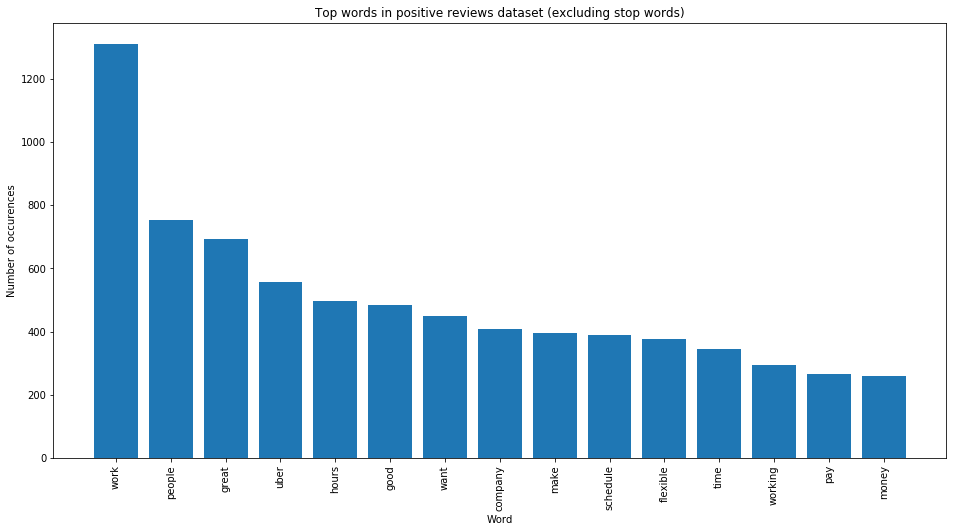

In [4]:
count_vectorizer = CountVectorizer(stop_words='english', min_df= 50,   lowercase= True )
words, counts = top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=pros_model)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)),counts);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in positive reviews dataset (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

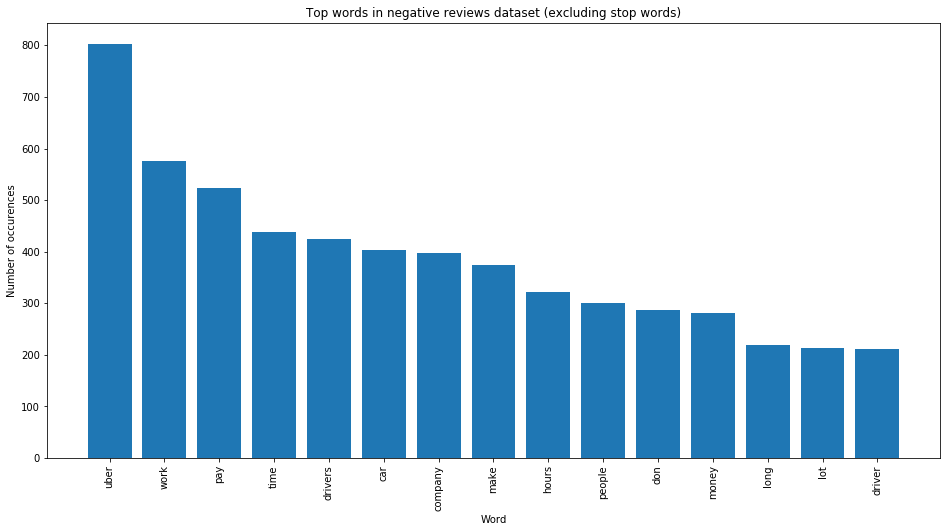

In [5]:
# count_vectorizer = CountVectorizer(stop_words='english')
words, counts = top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=cons_model)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)),counts);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in negative reviews dataset (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

We create a function to convert our reviews in the form of a matrix. This will cover both pros and cons review. We are analyzing and making the topic model on Pros & Cons **seperately**

In [0]:
def document_matrix(count_vectorizer ,review_type ):
  document_matrix_type= count_vectorizer.fit_transform(review_type.values)
  return document_matrix_type


  
  
  
  
  

In [0]:

positive_doc_matrix= document_matrix(count_vectorizer= count_vectorizer, review_type= pros_model)
negative_doc_matrix= document_matrix(count_vectorizer=count_vectorizer, review_type= cons_model)

**Latent Dirichilet Allocation** is a generative probability based approach to topic modeling. 

In [0]:
def Truncate(n_topics,  matrix_type):
  LDA_model = LatentDirichletAllocation( n_components=n_topics, max_iter=50, learning_method='online', 
                                          random_state=100, batch_size=64, n_jobs = -1)
  LDA_topic_matrix_type = LDA_model.fit_transform(matrix_type)
  return LDA_topic_matrix_type

In [0]:

Positive_SVD= Truncate(n_topics= 4, matrix_type= positive_doc_matrix)
Negative_SVD= Truncate(n_topics= 4, matrix_type= negative_doc_matrix)

Taking the  argmax  of each review_type in this topic matrix will give the predicted topics of each review_type in the sample. We can then sort these into counts of each topic.

In [0]:
# Define helper functions
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)


In [0]:
#Pros part
positive_LDA_keys= get_keys(Positive_SVD)
positive_lda_categories, positive_lda_counts = keys_to_counts(positive_LDA_keys)

#Cons_part
negative_LDA_keys= get_keys(Negative_SVD)
negative_lda_categories, negative_lda_counts = keys_to_counts(negative_LDA_keys)

In [12]:
print(len(negative_LDA_keys))
print(len(positive_LDA_keys))

3293
3293


In [0]:
n_topics= 4 #declaring this global variable to use in further functions. n_topics are the no. of topics we are creating.

In [48]:
print(negative_lda_categories)
print(negative_lda_counts)

[3, 2, 0, 1]
[832, 688, 883, 890]


In [47]:
print(positive_lda_categories)
print(positive_lda_counts)

[0, 2, 1, 3]
[513, 1133, 652, 995]


these topic categories are in and of themselves a little meaningless.

In order to better characterise them, it will be helpful to find the most frequent words in each

In [0]:
# Define helper functions
def get_top_n_words(n,  keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum= temp_vector_sum.toarray()
        
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [17]:
top_n_words_LDA_pros = get_top_n_words(10,   positive_LDA_keys, positive_doc_matrix, count_vectorizer)

for i in range(len(top_n_words_LDA_pros)):
    print("Topic {}: ".format(i+1), top_n_words_LDA_pros[i])

Topic 1:  growing pay money growth making getting things long management gas
Topic 2:  things team support fast bit issues pay drivers growth months
Topic 3:  things growth takes pay culture employees think customers benefits rates
Topic 4:  income rating feel maintenance things miles passengers support pay team


In [18]:
top_n_words_LDA_cons = get_top_n_words(10,   negative_LDA_keys, negative_doc_matrix, count_vectorizer)

for i in range(len(top_n_words_LDA_cons)):
    print("Topic {}: ".format(i+1), top_n_words_LDA_cons[i])

Topic 1:  uber drivers don management pay customers time company support employees
Topic 2:  pay car uber wear gas tear low vehicle driver time
Topic 3:  time hours make money long work job uber working like
Topic 4:  work company people lot life hard need balance uber fast


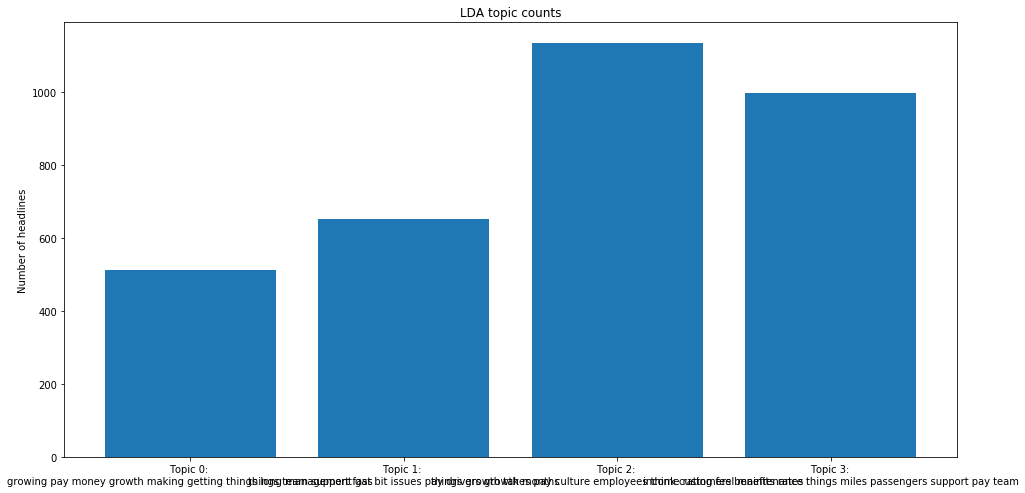

In [20]:
top_n_words_LDA_pros = get_top_n_words(10, positive_LDA_keys, positive_doc_matrix, count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_n_words_LDA_pros[i] for i in positive_lda_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(positive_lda_categories, positive_lda_counts);
ax.set_xticks(positive_lda_categories);
ax.set_xticklabels(labels);
ax.set_title('LDA topic counts');
ax.set_ylabel('Number of headlines');

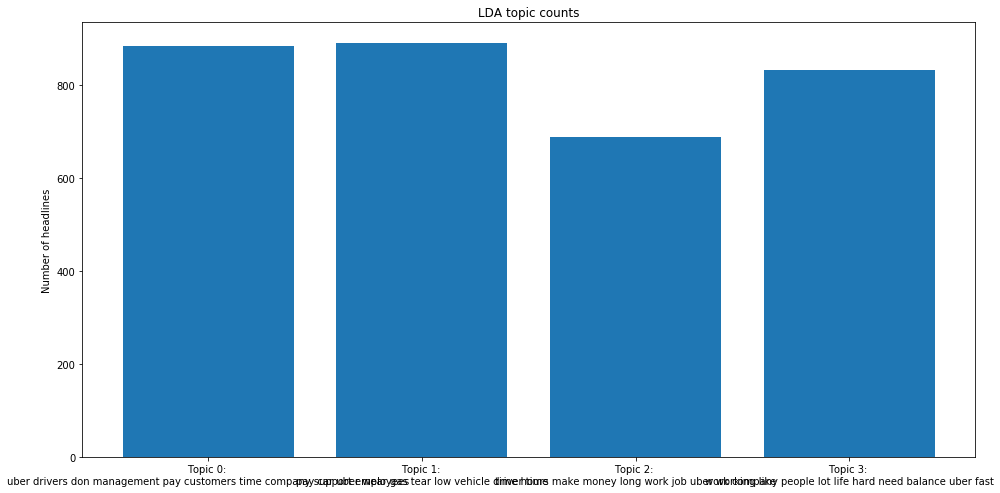

In [22]:
top_n_words_LDA_cons = get_top_n_words(10, negative_LDA_keys, negative_doc_matrix, count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_n_words_LDA_cons[i] for i in negative_lda_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(negative_lda_categories, negative_lda_counts);
ax.set_xticks(negative_lda_categories);
ax.set_xticklabels(labels);
ax.set_title('LDA topic counts');
ax.set_ylabel('Number of headlines');

We use a dimensionality-reduction technique called **t -SNE**, which will also serve to better illuminate the success of the clustering process.

In [21]:
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(Positive_SVD)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 3293 samples in 0.006s...
[t-SNE] Computed neighbors for 3293 samples in 0.111s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3293
[t-SNE] Computed conditional probabilities for sample 2000 / 3293
[t-SNE] Computed conditional probabilities for sample 3000 / 3293
[t-SNE] Computed conditional probabilities for sample 3293 / 3293
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.986671
[t-SNE] KL divergence after 2000 iterations: 0.430089


In [0]:
# Define helper functions
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [0]:
colormap = np.array([
    "#c7c7c7", "#aec7e8",  "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics]

In [25]:
lda_mean_topic_vectors = get_mean_topic_vectors(positive_LDA_keys, tsne_lda_vectors)

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lda_vectors[:,0], y=tsne_lda_vectors[:,1], color=colormap[positive_LDA_keys])

for t in range(n_topics):
    label = Label(x=lda_mean_topic_vectors[t][0], y=lda_mean_topic_vectors[t][1], 
                  text=top_n_words_LDA_pros[t], text_color=colormap[t])
    plot.add_layout(label)

show(plot)

**Now , we are done with our analysis. We are now going to update our excel sheet by mapping the right reviews with the right topics. **

In [0]:
topic_mapping_pros= {"growing pay money growth making getting things long management gas" : "0",
                     "things team support fast bit issues pay drivers growth months": "1",
                     "things growth takes pay culture employees think customers benefits rates" : "2",
                     "income rating feel maintenance things miles passengers support pay team" : "3" }





In [0]:
topic_indexes_list= list(map(str, positive_LDA_keys))

In [0]:
rev_topic_mapping_pros = { v:k for k,v in topic_mapping_pros.items()}
topic_mapped_positive_text= [rev_topic_mapping_pros.get(item,item)  for item in topic_indexes_list]

In [0]:
topic_mapping_cons= {"uber drivers don management pay customers time company support employees" :"0",
                     "pay car uber wear gas tear low vehicle driver time" : "1",
                     "time hours make money long work job uber working like" : "2",
                     "work company people lot life hard need balance uber fast" : "3" }

In [0]:
topic_indexes_list_cons= list(map(str, negative_LDA_keys))

In [0]:
rev_topic_mapping_cons = { v:k for k,v in topic_mapping_cons.items()}
topic_mapped_negative_text= [rev_topic_mapping_cons.get(item,item)  for item in topic_indexes_list_cons]

In [0]:
pros_cons_reviews_data["Pros_topics"]= topic_mapped_positive_text
pros_cons_reviews_data["Cons_topics"]= topic_mapped_negative_text

In [41]:
pros_cons_reviews_data

,Pros,Cons,Pros_topics,Cons_topics
0,"Good employee benefits, good intra company opp...",Processes are yet to be streamlined. A lot of ...,growing pay money growth making getting things...,work company people lot life hard need balance...
1,Nice environment and the work timings is great,No cons nice company to work,things growth takes pay culture employees thin...,work company people lot life hard need balance...
2,Good benfits and helps you grow in always,Nothing that i feel at the moment,growing pay money growth making getting things...,time hours make money long work job uber worki...
3,"You get the ownership of your work, you get fu...",As Uber shifts towards becoming a mature compa...,things team support fast bit issues pay driver...,work company people lot life hard need balance...
4,"Great team, culture, autonomy to employees, su...",None I can think of within three months of my ...,things growth takes pay culture employees thin...,work company people lot life hard need balance...
5,Extremely Friendly and Humble people with an e...,As an Intern cannot find any fault with the co...,things growth takes pay culture employees thin...,work company people lot life hard need balance...
6,"Culture, Career growth, Flexibility, Flat Hier...","Office politics, favouritism are two cons I ca...",things growth takes pay culture employees thin...,time hours make money long work job uber worki...
7,Low gender wage gap in entry-level and mid-man...,Almost a 7 day work week,things growth takes pay culture employees thin...,uber drivers don management pay customers time...
8,Company Culture is really nice.,Full-time Employees can make you feel unwanted...,things growth takes pay culture employees thin...,time hours make money long work job uber worki...
0,Uber has an amazing work culture and amazing b...,Location outside of bangalore city.,things growth takes pay culture employees thin...,uber drivers don management pay customers time...


In [0]:
pros_cons_reviews_data.to_csv("Uber_reviews_topic_modeled.csv", index= False)

In [0]:
 from google.colab import files
 files.download('Uber_reviews_topic_modeled.csv')